In [1]:
# Standard library imports
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers, backend as K
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, InputLayer, 
    RandomFlip, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import  DenseNet121 , ResNet50
from tensorflow.keras.callbacks import EarlyStopping
# Scikit-learn imports
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix


## data preprocessing

In [2]:
# Load the image using PIL
image = Image.open("/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg")
image_array=np.array(image)
image_shape=image_array.shape
print("image shape:",image_shape)

image shape: (1317, 1857)


In [3]:
import os
import random

def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            num_images = len(os.listdir(class_dir))  # Count images in the directory
            class_counts[class_name] = num_images
    return class_counts

def calculate_percentages(counts):
    total_count = sum(counts.values())
    percentages = {class_name: f"{(count / total_count) * 100:.2f}%" for class_name, count in counts.items()}
    return percentages

def create_image_label_file(directory, output_file):
    image_label_pairs = []
    
    # Map class names to labels
    class_to_label = {
        "NORMAL": 0,
        "PNEUMONIA": 1
    }

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            label = class_to_label.get(class_name.upper())  # Get label for the class name
            if label is not None:  # Proceed if label exists
                for image_name in os.listdir(class_dir):
                    image_path = os.path.join(class_dir, image_name)
                    # Append image path and label to the list
                    image_label_pairs.append(f"{image_path},{label}\n")

    # Shuffle the list of image-label pairs
    random.shuffle(image_label_pairs)

    # Write the shuffled pairs to the output file
    with open(output_file, 'w') as f:
        f.writelines(image_label_pairs)

# Specify your train, val, and test directories
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

# Create text files for train, validation, and test datasets
create_image_label_file(train_dir, 'train_image_labels.txt')
create_image_label_file(val_dir, 'val_image_labels.txt')
create_image_label_file(test_dir, 'test_image_labels.txt')

# Count images in train, validation, and test directories
train_counts = count_images_in_directory(train_dir)
val_counts = count_images_in_directory(val_dir)
test_counts = count_images_in_directory(test_dir)

# Calculate percentages
train_percentages = calculate_percentages(train_counts)
val_percentages = calculate_percentages(val_counts)
test_percentages = calculate_percentages(test_counts)

# Print results
print("*" * 85)
print("Train counts:", train_counts)
print("Train percentages:", train_percentages)
print("*" * 85)
print("Validation counts:", val_counts)
print("Validation percentages:", val_percentages)
print("*" * 85)
print("Test counts:", test_counts)
print("Test percentages:", test_percentages)
print("*" * 85)


*************************************************************************************
Train counts: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Train percentages: {'PNEUMONIA': '74.29%', 'NORMAL': '25.71%'}
*************************************************************************************
Validation counts: {'PNEUMONIA': 8, 'NORMAL': 8}
Validation percentages: {'PNEUMONIA': '50.00%', 'NORMAL': '50.00%'}
*************************************************************************************
Test counts: {'PNEUMONIA': 390, 'NORMAL': 234}
Test percentages: {'PNEUMONIA': '62.50%', 'NORMAL': '37.50%'}
*************************************************************************************


In [4]:


# Define the class labels specific to your X-ray dataset
classes = {
    0: 'normal',     # Normal X-ray
    1: 'pneumonia'   # Pneumonia X-ray
}

def load_paths_labels(path):
    """Load image paths and labels from a text file."""
    with open(path, 'r') as file:
        paths_labels = file.readlines()
    return paths_labels

def handle_images_path_and_labels(paths_labels):
    """Process the loaded paths and labels to generate usable image paths and labels."""
    paths = []
    labels = []
    for line in paths_labels:
        temp = line.strip().split(",")  # Split to extract image name and label
        image_name = temp[0]
        try:
            label = int(temp[1])  # Convert label to integer
            paths.append(image_name)  # Use relative path or adjust to your directory structure
            labels.append(label)
        except (ValueError, IndexError):
            print(f"Invalid line format: {line}")  # Improved error handling
    return paths, labels

def get_patch(paths, labels, patch_size):
    """Yield patches of paths and labels based on the specified patch size."""
    for i in range(0, len(labels), patch_size):
        yield paths[i:i + patch_size], labels[i:i + patch_size]

def load_images_patch(paths, target_size):
    """Load images from the given paths and resize them to target_size."""
    images = []
    for path in paths:
        try:
            img = Image.open(path).convert('RGB')  # Ensure images are in RGB format
            img = img.resize(target_size)  # Resize image to target size
            img_array = np.array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return np.array(images)

def read_image_labels(path, patch_size, image_shape):
    """Read image paths and labels, preparing a dataset for training."""
    paths_labels = load_paths_labels(path)
    paths, labels = handle_images_path_and_labels(paths_labels)

    def generator():
        """Yield image patches and their corresponding labels."""
        for images_path, images_labels in get_patch(paths, labels, patch_size):
            images = load_images_patch(images_path, image_shape[:2])  # Pass the target size
            yield images, np.array(images_labels)

    # Create a TensorFlow dataset from the generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, image_shape[0], image_shape[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int8)
        )
    )

    # Define a preprocessing function to normalize images
    def preprocess(images, labels):
        images = tf.cast(images, tf.float32) / 255.0  # Normalize pixel values to the range [0, 1]
        return images, labels  # Return preprocessed images and labels

    # Apply preprocessing to the dataset
    dataset = dataset.map(preprocess)

    return dataset  # Return the prepared dataset

# Function to extract labels from dataset
def extract_labels(dataset):
    labels = []
    images = []
    for batch_images, batch_labels in dataset:
        images.extend(batch_images.numpy())
        labels.extend(batch_labels.numpy())
    return np.array(images), np.array(labels)

batch_size = 32
image_size = (224, 224)
# Create train, validation, and test datasets
train_dataset = read_image_labels("/kaggle/working/train_image_labels.txt", batch_size, image_size)
val_dataset = read_image_labels("/kaggle/working/val_image_labels.txt", batch_size, image_size)
test_dataset = read_image_labels("/kaggle/working/test_image_labels.txt", batch_size, image_size)

# Fetch a batch of images and labels
images_batch, labels_batch = next(iter(train_dataset))


In [5]:
image_shape_final=images_batch[0].shape
print("image shape:",image_shape_final)

image shape: (224, 224, 3)


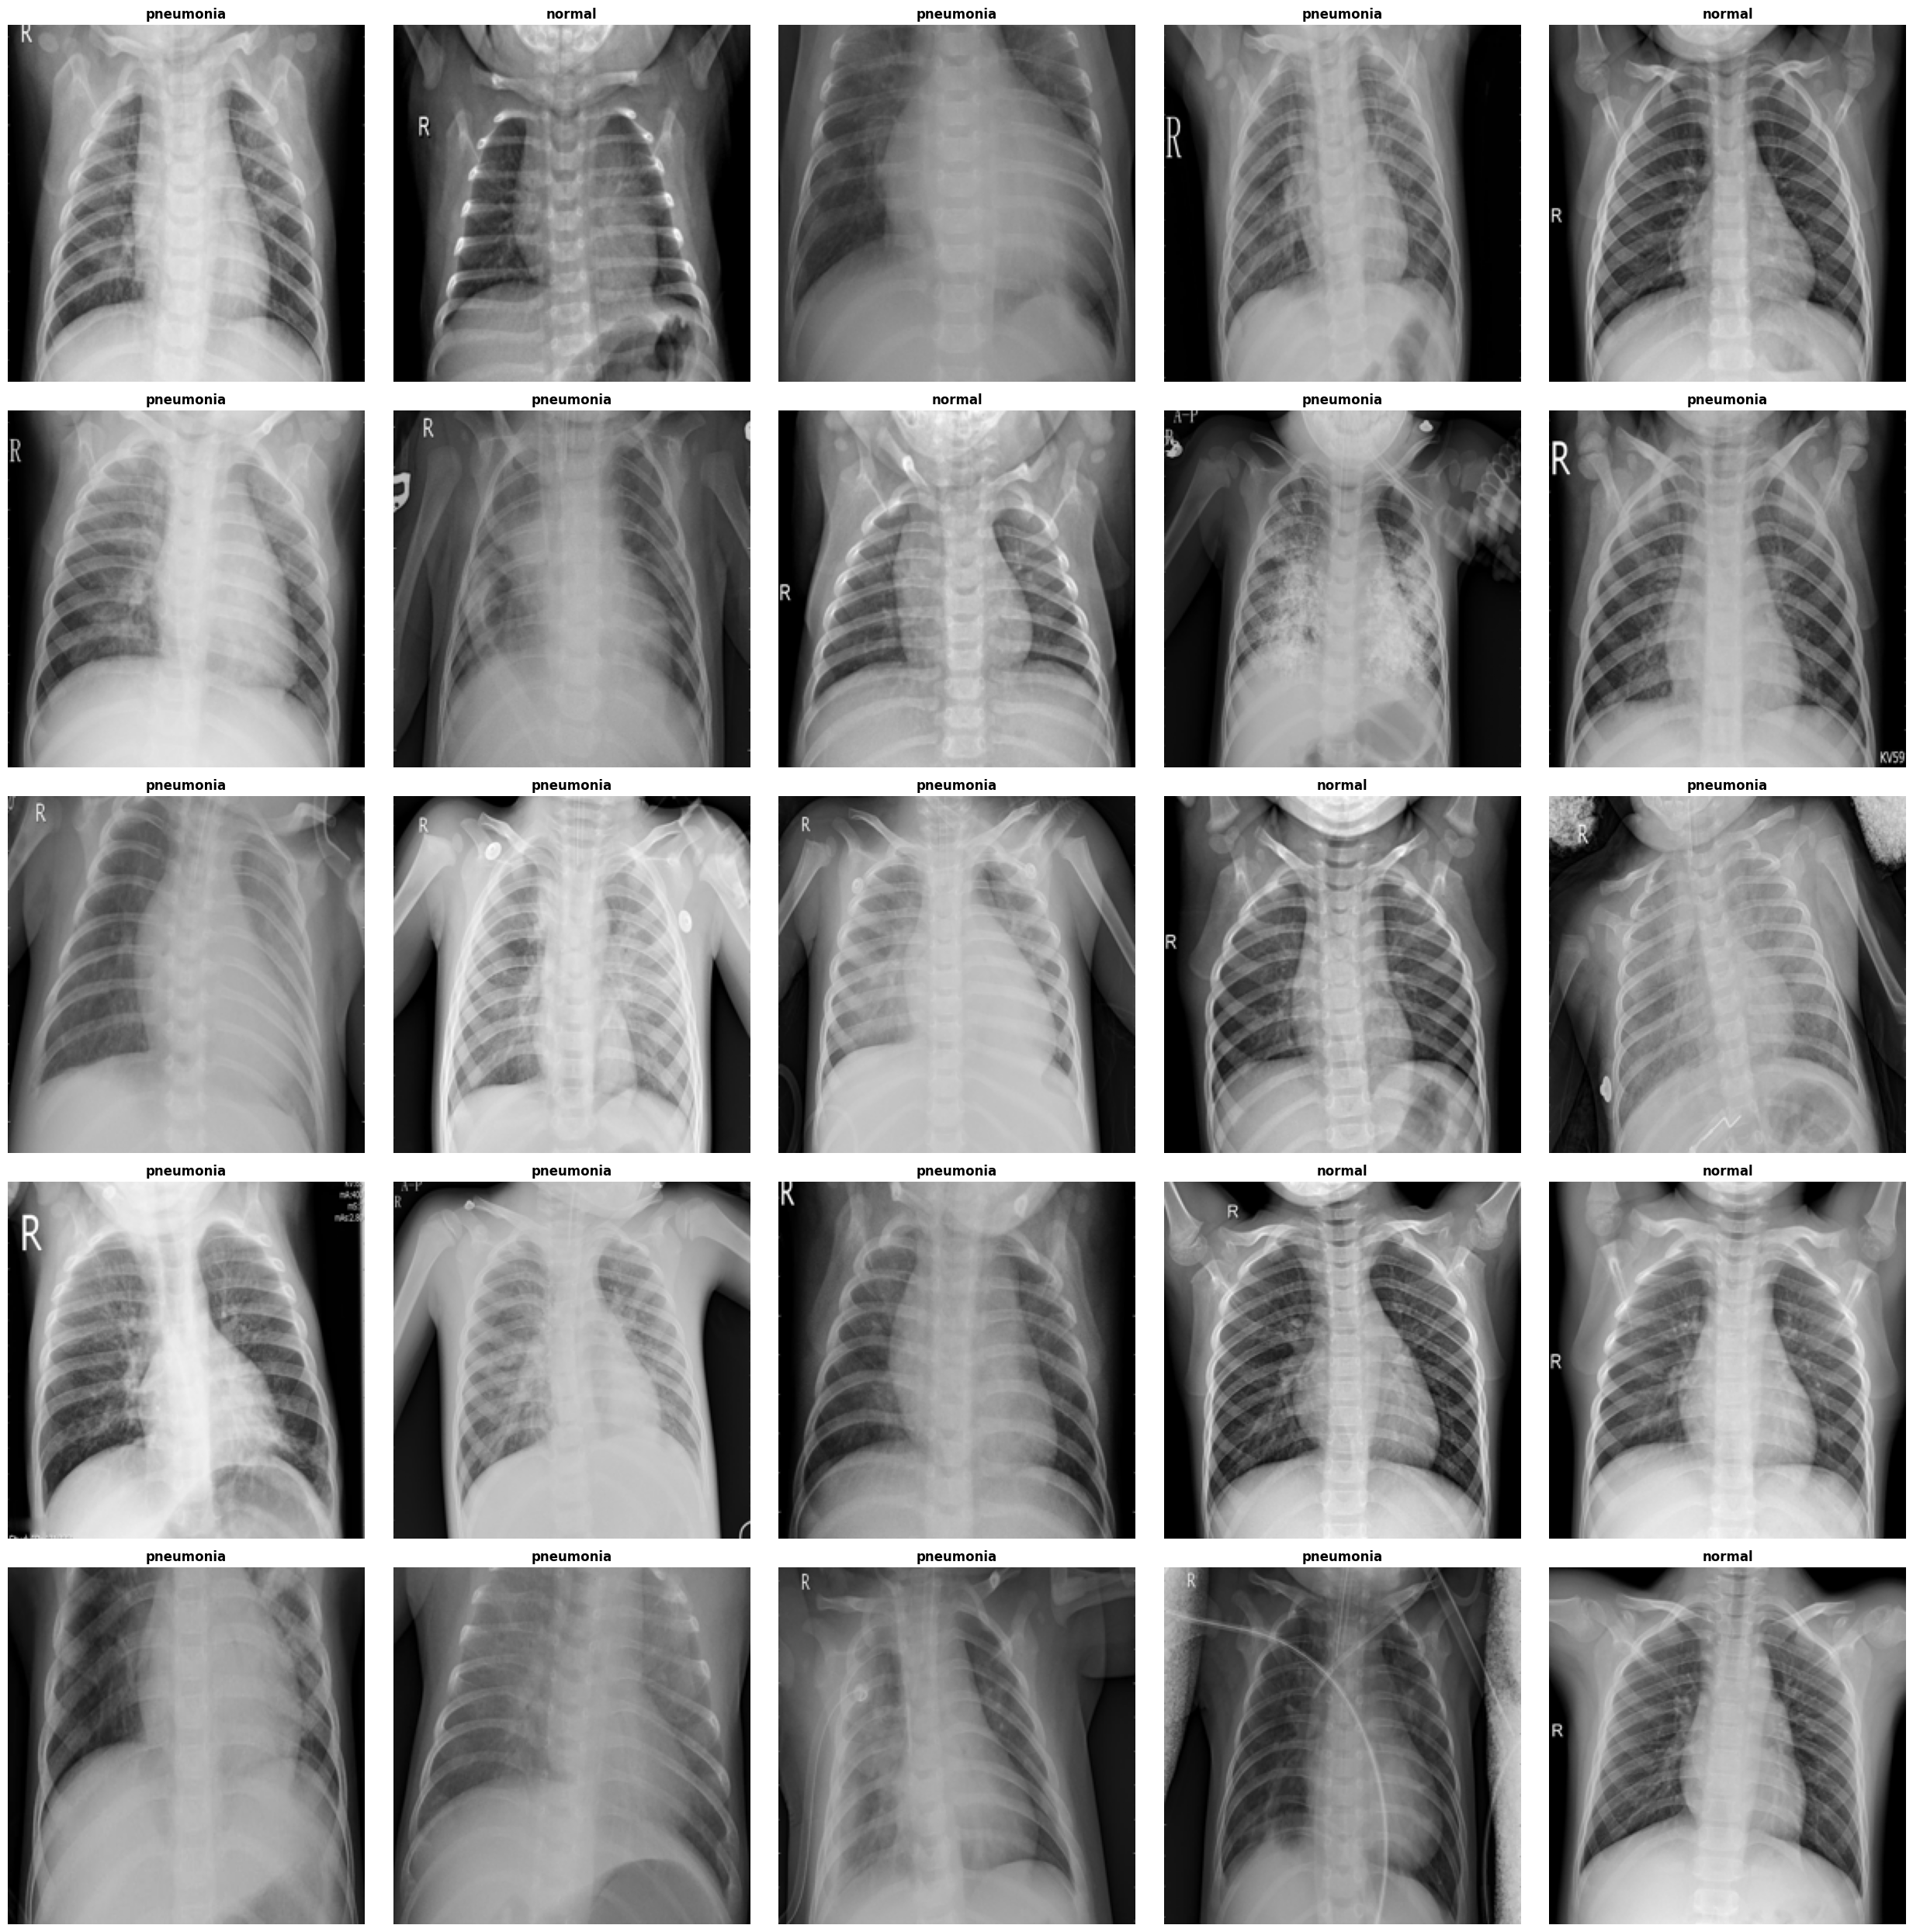

In [6]:
classes={0:"normal",1:"pneumonia"}
def show_images(images_patch, labels):
    """
    Display a grid of images with their corresponding labels.

    Parameters:
    - images_patch (list or array-like): A collection of image arrays to display.
    - labels (list or array-like): Labels corresponding to each image in `images_patch`.
    """

    # Calculate the number of images per row and column
    images_num = int(np.sqrt(len(images_patch)))

    # Create a grid of subplots with `images_num` rows and `images_num` columns
    fig, ax = plt.subplots(images_num, images_num, figsize=(images_num *5, images_num *5))

    count = 0  # Initialize a counter to keep track of the current image index

    # Loop over the rows of the subplot grid
    for i in range(images_num):
        # Loop over the columns of the subplot grid
        for j in range(images_num):
            if count < len(images_patch):
                # Display the image at the current index in the subplot
                # images_patch[count]=
                ax[i][j].imshow(images_patch[count])

                # Set the title of the subplot to the label of the current image
                ax[i][j].set_title(classes[int(labels[count])], fontweight='bold')

                # Hide the axis for the current subplot
                ax[i][j].set_axis_off()

                count += 1  # Increment the counter for the next image

#     # Set a title for the entire grid of images
#     fig.suptitle('Grid of Train Images', fontsize=30, fontweight='bold')

    # Adjust layout to prevent overlap and ensure proper spacing
    plt.tight_layout()

    # Display the grid of images
    plt.show()
    
show_images(images_batch, labels_batch)

## model choosing 

In [10]:
DenseNet121_ = DenseNet121(input_shape=image_shape_final, include_top=False, weights='imagenet')
ResNet50_ = ResNet50(input_shape=image_shape_final, include_top=False, weights='imagenet')

# Corrected spelling for `trainable`
DenseNet121_.trainable = False
ResNet50_.trainable = False


In [11]:
class_len=2



ResNet50_clf = Sequential([
    InputLayer(input_shape=image_shape_final),
    ResNet50_,
    GlobalAveragePooling2D(),
    Dense(class_len, activation='softmax')
])

DenseNet121_clf = Sequential([
    InputLayer(input_shape=image_shape_final),
    DenseNet121_,
    GlobalAveragePooling2D(),
    Dense(class_len, activation='softmax')
])




In [12]:
models_list=[ResNet50_clf,DenseNet121_clf]

print("*"*90)
for i in models_list:
  print("*"*90)
  print(i.summary())
  print("*"*90)
print("*"*90)

******************************************************************************************
******************************************************************************************


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
******************************************************************************************
******************************************************************************************


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

None
******************************************************************************************
******************************************************************************************


In [13]:
models_list_names=["ResNet50_clf","DenseNet121_clf"]
def train_and_evaluate_models(models_list, train_dataset, validation_dataset, epochs, batch_size, final_model, l_r,best_model_name="", patience=3):
    """
    Trains a list of models and evaluates their validation accuracy.
    ...
    """
    model_performance = {}
    length = len(models_list)
    
    for i, model in enumerate(models_list):
        print("*" * 90)
        if(final_model):
            string_me=best_model_name
        else:
            string_me=models_list_names[i]
        print(f"Training model: {string_me}   {i + 1}/{length}...")

        # Compile the model
        model.compile(Adam(learning_rate=l_r),
                      loss=SparseCategoricalCrossentropy(),
                      metrics=["accuracy"])

        # Set up EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True,min_delta=0.006)

        # Train the model with EarlyStopping
        history = model.fit(
              x=train_dataset,                      # Input data for training
              y=None,                               # Labels (not required when using a generator)
             epochs=epochs,                        # Number of epochs to train the model
             batch_size=batch_size,                # Number of samples per gradient update
             validation_data=validation_dataset,   # Data on which to evaluate the loss and any model metrics at the end of each epoch
             validation_steps=None,                # Optional, number of steps to yield from validation generator before stopping
             callbacks=[early_stopping]           # List of callback functions to apply during training
)


        # Store the validation accuracy of the final epoch
        val_accuracy = history.history['val_accuracy'][-1]
        model_performance[f"build_model_{i + 1}"] = val_accuracy
        print(f"Model {string_me} {i + 1} validation accuracy: {val_accuracy}")
        print("*" * 90)

        if not final_model:
            # Clear the session to free memory
            tf.keras.backend.clear_session()
            # Delete the model objects and force garbage collection
            del model
            gc.collect()
        else:
            # Return the best model if final_model is True
            return model, history

    # Find the best model based on validation accuracy
    best_model_name = max(model_performance, key=model_performance.get)
    best_model_val_accuracy = model_performance[best_model_name]

    print(f"The best model is {best_model_name} with a val accuracy of {best_model_val_accuracy}")

    return model_performance, best_model_name


In [ ]:
print(5)

In [14]:
epochs=3
model_performance, best_model_name=train_and_evaluate_models(models_list, train_dataset,test_dataset, epochs, 32, False,.002) 

******************************************************************************************
Training model: ResNet50_clf   1/2...
Epoch 1/3


I0000 00:00:1730061863.220163      69 service.cc:145] XLA service 0x784ea40027b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730061863.220222      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


      2/Unknown 13s 69ms/step - accuracy: 0.4297 - loss: 0.8343

I0000 00:00:1730061868.940645      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    163/Unknown 177s 1s/step - accuracy: 0.7313 - loss: 0.5845

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7313 - loss: 0.5842 - val_accuracy: 0.6330 - val_loss: 0.5874
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 765ms/step - accuracy: 0.7677 - loss: 0.4601 - val_accuracy: 0.6939 - val_loss: 0.5432
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 768ms/step - accuracy: 0.8052 - loss: 0.4112 - val_accuracy: 0.7179 - val_loss: 0.5268
Model ResNet50_clf 1 validation accuracy: 0.7179487347602844
******************************************************************************************
******************************************************************************************
Training model: DenseNet121_clf   2/2...
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 160s 842ms/step - accuracy: 0.8736 - loss: 0.2981 - val_accuracy: 0.7660 - val_loss: 0.5305
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 761ms/step - accuracy: 0.9470 - loss: 0.1329 - val_accuracy: 0.7500 - val_loss: 0.6427
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 759ms/step - accuracy: 0.9602 

## Model training

In [16]:
batch_size = 32
image_size = (512, 512)
# Create train, validation, and test datasets
train_dataset = read_image_labels("/kaggle/working/train_image_labels.txt", batch_size, image_size)
val_dataset = read_image_labels("/kaggle/working/val_image_labels.txt", batch_size, image_size)
test_dataset = read_image_labels("/kaggle/working/test_image_labels.txt", batch_size, image_size)


DenseNet121__ = DenseNet121(input_shape=(512,512,3), include_top=False, weights='imagenet')
# Corrected spelling for `trainable`
DenseNet121__.trainable = False

DenseNet121_clf_ = Sequential([
    InputLayer(input_shape=[*image_size,3]),
    DenseNet121__,
    GlobalAveragePooling2D(),
    Dense(class_len, activation='softmax')
])


#train the best model
epochs=3
model, history=train_and_evaluate_models( [DenseNet121_clf_], train_dataset,test_dataset,epochs, 32, True,.001,best_model_name)

******************************************************************************************
Training model: build_model_2   1/1...
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.8278 - loss: 0.3974 - val_accuracy: 0.8446 - val_loss: 0.3700
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9341 - loss: 0.1941 - val_accuracy: 0.8558 - val_loss: 0.3660
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9425 - loss: 0.1634 - val_accuracy: 0.8574 - val_loss: 0.3695
Model build_model_2 1 validation accuracy: 0.8573718070983887
******************************************************************************************


In [17]:
def plot_accuracy( history, string="Validation"):
    """
    Plots the accuracy and loss for both training and validation over epochs.

    Parameters:
    - epoch (int): The total number of epochs.
    - history (History object): The history object returned by the model training process (e.g., from Keras).
    - string (str, optional): Custom label for the validation metrics. Defaults to "Validation".

    This function creates two subplots: one for accuracy and one for loss, comparing
    training and validation metrics over the number of epochs.
    """

    # Generate an array of epoch numbers (e.g., [1, 2, ..., epoch])
   

    # Extract the accuracy and loss data from the history object
    train_accuracy = history.history['accuracy']          # Training accuracy
    val_accuracy = history.history.get('val_accuracy')    # Validation accuracy (use .get() in case there's no validation)
    train_loss = history.history['loss']                  # Training loss
    val_loss = history.history.get('val_loss')            # Validation loss (use .get() for safety)
    epoch=len(train_accuracy)
    epochs = np.arange(1, epoch + 1)

    # Create a figure with two subplots (1 row, 2 columns)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Accuracy Plot
    ax[0].plot(epochs, train_accuracy, label="Train Accuracy", color="b", linestyle="--", linewidth=2, marker='o', alpha=0.7)
    if val_accuracy:
        ax[0].plot(epochs, val_accuracy, label=f"{string} Accuracy", color="g", linestyle=":", linewidth=2, marker='s', alpha=0.7)
    ax[0].set_title("Accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].grid(True)  # Add a grid for better readability
    ax[0].set_ylim([0, 1])

    # Loss Plot
    ax[1].plot(epochs, train_loss, label="Train Loss", color="r", linestyle="--", linewidth=2, marker='o', alpha=0.7)
    if val_loss:
        ax[1].plot(epochs, val_loss, label=f"{string} Loss", color="m", linestyle=":", linewidth=2, marker='s', alpha=0.7)
    ax[1].set_title("Loss")
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].grid(True)  # Add a grid for better readability
    ax[1].set_ylim([0, max(val_loss)+1])

    # Adjust layout for better spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()



def plot_testing_confusion_heat_map(y_test_act, y_test_pred, str6=""):
    # Confusion matrix for testing data
    clf_matrix_test = confusion_matrix(y_test_act, y_test_pred, normalize='true') * 100
    clf_matrix_str_test = np.round(clf_matrix_test, 1).astype(str)

    size = 8
    plt.rcParams.update({'font.size': size, 'font.family': 'Times New Roman'})

    # Create a figure for the heatmap
    fig, ax_test = plt.subplots(figsize=(8, 5))

    # Plot for testing heatmap
    sns.heatmap(clf_matrix_test, annot=clf_matrix_str_test, annot_kws={'weight': "bold"}, fmt='s',
                cmap='YlGnBu', cbar=False, ax=ax_test)

    ax_test.set_xlabel('Predicted Label', size=size + 2, fontweight='bold')
    ax_test.set_ylabel('True Label', size=size + 2, fontweight='bold')
    ax_test.tick_params(axis='both', which='major', labelsize=size + 1)
    ax_test.set_xticklabels(ax_test.get_xticklabels(), fontweight='bold')
    ax_test.set_yticklabels(ax_test.get_yticklabels(), fontweight='bold')

    # Add a color bar for the heatmap
    cbar = fig.colorbar(ax_test.collections[0], ax=ax_test, location='right', pad=0.02, shrink=1)
    cbar.ax.tick_params(labelsize=size + 1)
    cbar.set_label('Accuracy (%)', size=size + 1, fontweight='bold')
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontweight='bold')

    # Add subplot title
    fig.text(0.4, 0.92, 'Confusion Matrix (Testing)', fontsize=size + 3, fontweight='bold', ha='center')

    plt.show()





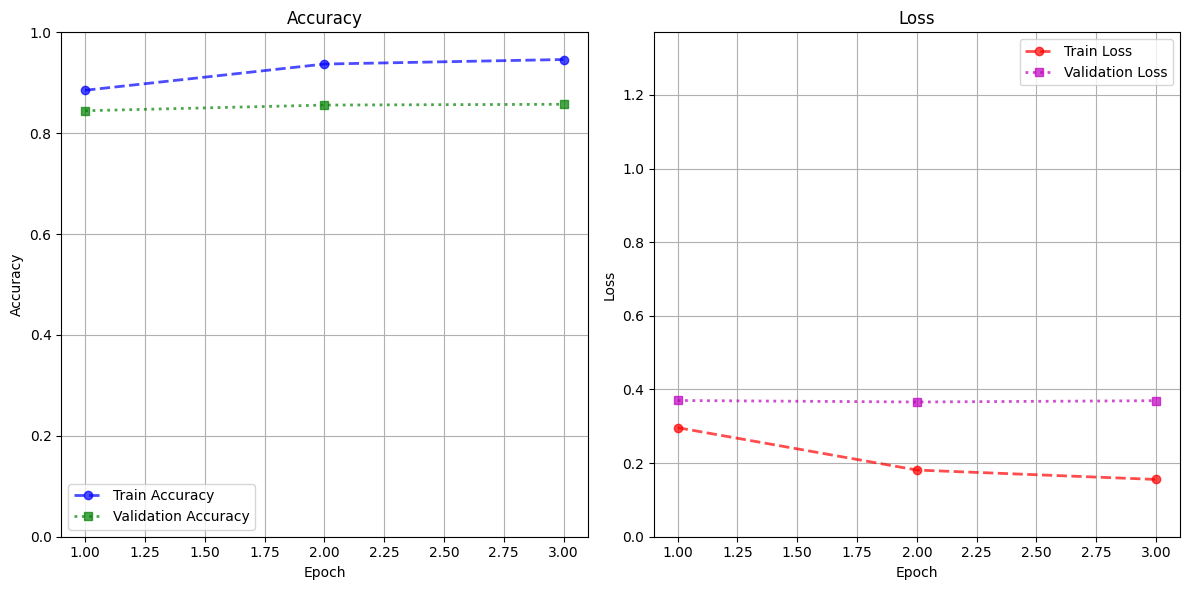

In [18]:
plot_accuracy( history, string="Validation")


## model testing

In [23]:
# Make predictions
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted class indices

# Get true labels from the dataset
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Convert true labels to a numpy array
true_labels = np.array(true_labels)


# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_classes, average='weighted') 
print(f'F1 Score: {f1:.4f}')

# Generate a classification report
report = classification_report(true_labels, predicted_classes, target_names=classes.values())
print(report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 921ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Accuracy: 0.8446
F1 Score: 0.8362
              precision    recall  f1-score   support

      normal       0.94      0.63      0.75       234
   pneumonia       0.81      0.97      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.84      0.84       624



/tmp/ipykernel_30/1096351718.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontweight='bold')


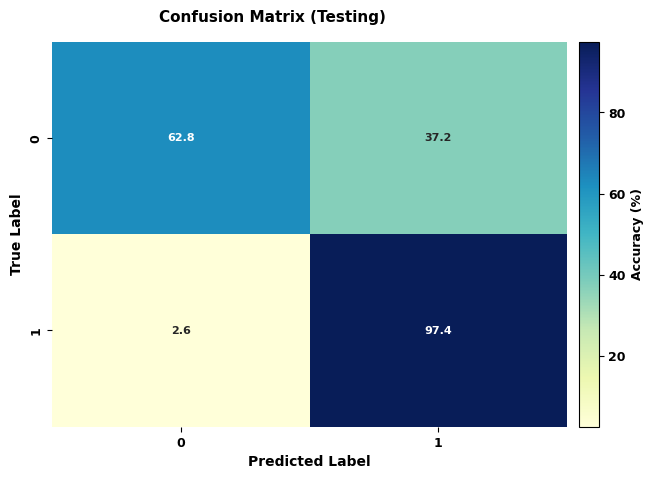

In [20]:
plot_testing_confusion_heat_map(true_labels, predicted_classes, str6="")

In [22]:
model.save("chest_xray_model.h5")
model.save("chest_xray_model.keras")